In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Code01 Essentials(from previous research)

### Evauation Function

In [2]:
# evaluation function (code from https://competitions.codalab.org/forums/22145/4564/)
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)
#     if len(left) != len(right):
#     message = 'left and right lengths are not the same'
#     sys.exit(message)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    # print(submission_preference)
    return submission_preference

### Get Datas

In [3]:
# dataframes
data = pd.read_csv('data/train_data/train_task_3_4.csv')
eval_vali = pd.read_csv('data/test_data/quality_response_remapped_public.csv')
eval_test = pd.read_csv('data/test_data/quality_response_remapped_private.csv')

# submission template
template = pd.read_csv('submission/template.csv')

# metadatas
student_metadata = pd.read_csv('data/metadata/student_metadata_task_3_4.csv')
subject_metadata = pd.read_csv('data/metadata/subject_metadata.csv')
answer_metadata = pd.read_csv('data/metadata/answer_metadata_task_3_4.csv')
question_metadata = pd.read_csv('data/metadata/question_metadata_task_3_4.csv')

### Data Preprocessing

In [4]:
def preprocess_mydata(data, question_metadata):
    # 1. Subject Grouping - SubId
    QMD = question_metadata.copy()
    QMD['SubId'] = QMD.SubjectId.apply(lambda x: x[1:-2].split(', ')[1])
    QMD.drop(columns=['SubjectId'], inplace=True)

    # 2. Position of Correct Answer - CorrectAnswer
    DT = data.copy()
    DT.drop(columns=['UserId', 'AnswerId','IsCorrect', 'AnswerValue'], inplace=True)
    DT.drop_duplicates(['QuestionId'], inplace=True, ignore_index=True)

    # 3. Ratio of Correct Resopnse - CRRatio
    DT2 = data.copy()
    DT2.drop(columns=['UserId', 'AnswerId', 'CorrectAnswer', 'AnswerValue'], inplace=True)
    CRR = DT2.groupby('QuestionId').mean().rename(columns={'IsCorrect':'CRRatio'})

    # merge to Submission Template 
    mydata = pd.read_csv('submission/template.csv')
    mydata = pd.merge(left = mydata, right = QMD, how = 'inner', on = 'QuestionId')
    mydata = pd.merge(mydata, DT, 'inner', 'QuestionId')
    mydata = pd.merge(mydata, CRR, 'inner', 'QuestionId')
    
    return mydata

mydata = preprocess_mydata(data, question_metadata)

### Preperation for Fitting

In [5]:
# assign random ranking between 0 and 1 then sort by validation data
def assign_random_ranking(rand_seed, mydata, eval_vali):
    # get every quesion ids used in validation set
    qids_of_vali = eval_vali.left.tolist() + eval_vali.right.tolist()
    qids_of_vali.sort()

    # assign random ranking to every questions
    np.random.seed(rand_seed)
    mydata.ranking = np.random.rand(len(mydata))

    # set the sole decision(Final) from five evaluator decisions
    eVali = eval_vali.copy()
    eTest = eval_test.copy()
    eVali['Final'] = eVali.filter(regex='^T', axis = 1).mean(axis=1).apply(lambda x: 2 if x > 1.5 else 1)
    eTest['Final'] = eTest.filter(regex='^T', axis = 1).mean(axis=1).apply(lambda x: 2 if x > 1.5 else 1)

    # swap ranking values to based on Final decision
    for row in eVali.itertuples():
        if row.Final == 1:
            if mydata[mydata.QuestionId == row.left].ranking.values[0] < mydata[mydata.QuestionId == row.right].ranking.values[0]:
                tmp = mydata[mydata.QuestionId == row.left].ranking.values[0]
                mydata[mydata.QuestionId == row.left].ranking.values[0]= mydata[mydata.QuestionId == row.right].ranking.values[0]
                mydata[mydata.QuestionId == row.right].ranking.values[0]= tmp
        elif row.Final == 2:
            if mydata[mydata.QuestionId == row.left].ranking.values[0]> mydata[mydata.QuestionId == row.right].ranking.values[0]:
                tmp = mydata[mydata.QuestionId == row.left].ranking.values[0]
                mydata[mydata.QuestionId == row.left].ranking.values[0]= mydata[mydata.QuestionId == row.right].ranking.values[0]
                mydata[mydata.QuestionId == row.right].ranking.values[0]= tmp
    return eVali, eTest

eVali, eTest = assign_random_ranking(20182453, mydata, eval_vali)

### Fitting

In [6]:
# separate mydata(1: data in validation set, 2: data not in validataion set)
def separate_mydata(mydata, eval_vali):
    # get every quesion ids used in validation set
    qids_of_vali = eval_vali.left.tolist() + eval_vali.right.tolist()
    qids_of_vali.sort()

    # seperate mydata(stanard - if question is in validation set)
    mydata_in_vali = mydata[mydata.QuestionId.isin(qids_of_vali)].copy()
    mydata_not_vali = mydata[~mydata.QuestionId.isin(qids_of_vali)].copy()
    
    return mydata_in_vali, mydata_not_vali

mydata_in_vali, mydata_not_vali = separate_mydata(mydata, eval_vali)

In [7]:
# # fit linear regression model(in validation set group)
y = mydata_in_vali[['ranking']]
X = mydata_in_vali[['SubId', 'CorrectAnswer', 'CRRatio']]
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([0.70814095]), array([[-0.002403  ,  0.02228532, -0.43510357]]))

In [8]:
# # predict ranking by fit model to non-validation data
X2 = mydata_not_vali[['SubId', 'CorrectAnswer', 'CRRatio']]
mydata_not_vali['ranking'] = lin_reg.predict(X2)

mydata.update(mydata_not_vali)

In [9]:
# # export result
# mydata[['QuestionId', 'ranking']].to_csv('submission/Result01.csv', index=False)

### Evaluation

In [10]:
estimateV = evaluate(eval_test, mydata)
trueV = eTest['Final'].tolist()

ev = np.array(estimateV)
tv = np.array(trueV)

samev = (ev == tv)
samev.sum() / samev.size

0.4

# Code02 - Model Improvement

## 1. Hypothesis test for Former model

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
# Init mydata
mydata = preprocess_mydata(data, question_metadata)
eVali, eTest = assign_random_ranking(20182453, mydata, eval_vali)
mydata_in_vali, mydata_not_vali = separate_mydata(mydata, eval_vali)

In [13]:
# fit model
lm_former = smf.ols(formula='ranking ~ SubId+CorrectAnswer+CRRatio', data=mydata_in_vali)
lm_former_fit = lm_former.fit()
lm_former_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9786
Date:                Sun, 18 Jun 2023   Prob (F-statistic):              0.429
Time:                        23:26:56   Log-Likelihood:                -7.6962
No. Observations:                  49   AIC:                             25.39
Df Residuals:                      44   BIC:                             34.85
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6336      0.210      3.012      0.004       0.210       1.057
SubId[T.49]      -0.0544      0.163     -0.334      0.740      -0.383       0.274
SubId[T.71]      -0.0941      0.090     -1.047      0.301      -0.275       0.087
CorrectAnswer     0.0222      0.043      0.522      0.604      -0.063       0.108
CRRatio          -0.4368      0.304     -1.436      0.158      -1.050       0.176
==============================================================================
Omnibus:                        6.468   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                2.333
Skew:                           0.092   Prob(JB):                        0.311
Kurtosis:                       1.947   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# predict
mydata_not_vali['ranking'] = lm_former_fit.predict(mydata_not_vali)
mydata.update(mydata_not_vali)

In [15]:
estimateV = evaluate(eval_test, mydata)
trueV = eTest['Final'].tolist()

ev = np.array(estimateV)
tv = np.array(trueV)

samev = (ev == tv)
samev.sum() / samev.size

0.4

## 2. Tweak Predictors(SubId, CorrectAnswer)

In [16]:
# Init mydata
mydata = preprocess_mydata(data, question_metadata)

In [17]:
Subjs = pd.get_dummies(mydata['SubId'], prefix='Subj')
Anss = pd.get_dummies(mydata['CorrectAnswer'], prefix='Ans')
mydata = pd.concat([mydata, Subjs], axis=1)
mydata = pd.concat([mydata, Anss], axis=1)
mydata.drop(columns=['SubId', 'CorrectAnswer'], inplace=True)
mydata

,QuestionId,ranking,CRRatio,Subj_32,Subj_49,Subj_71,Ans_1,Ans_2,Ans_3,Ans_4
0,0,NaN,0.443457,1,0,0,1,0,0,0
1,1,NaN,0.571429,1,0,0,0,0,1,0
2,2,NaN,0.385214,1,0,0,0,1,0,0
3,3,NaN,0.808757,1,0,0,0,1,0,0
4,4,NaN,0.401408,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
943,943,NaN,0.566528,1,0,0,0,0,0,1
944,944,NaN,0.142857,1,0,0,0,0,0,1
945,945,NaN,0.422336,1,0,0,1,0,0,0
946,946,NaN,0.459459,1,0,0,0,1,0,0


In [18]:
eVali, eTest = assign_random_ranking(20182453, mydata, eval_vali)
mydata_in_vali, mydata_not_vali = separate_mydata(mydata, eval_vali)

In [19]:
# fit model
lm = smf.ols(formula='ranking ~ Subj_32+Subj_49+Subj_71+Ans_1+Ans_2+Ans_3+Ans_4+CRRatio', data=mydata_in_vali)
lm_fit = lm.fit()
lm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.7372
Date:                Sun, 18 Jun 2023   Prob (F-statistic):              0.623
Time:                        23:26:56   Log-Likelihood:                -7.3309
No. Observations:                  49   AIC:                             28.66
Df Residuals:                      42   BIC:                             41.90
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4050      0.105      3.869      0.000       0.194       0.616
Subj_32        0.1784      0.075      2.389      0.021       0.028       0.329
Subj_49        0.1363      0.120      1.138      0.262      -0.105       0.378
Subj_71        0.0904      0.075      1.201      0.236      -0.061       0.242
Ans_1          0.0962      0.081      1.193      0.240      -0.067       0.259
Ans_2          0.0362      0.077      0.469      0.641      -0.119       0.192
Ans_3          0.1108      0.083      1.336      0.189      -0.057       0.278
Ans_4          0.1619      0.099      1.638      0.109      -0.038       0.361
CRRatio       -0.4260      0.310     -1.373      0.177      -1.052       0.200
==============================================================================
Omnibus:                        4.785   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                2.075
Skew:                           0.132   Prob(JB):                        0.354
Kurtosis:                       2.027   Cond. No.                     2.58e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.45e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
# predict
mydata_not_vali['ranking'] = lm_fit.predict(mydata_not_vali)
mydata.update(mydata_not_vali)
mydata

,QuestionId,ranking,CRRatio,Subj_32,Subj_49,Subj_71,Ans_1,Ans_2,Ans_3,Ans_4
0,0.0,0.490701,0.443457,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.450811,0.571429,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0.455494,0.385214,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.0,0.275047,0.808757,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,0.046299,0.401408,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
943,943.0,0.503989,0.566528,1.0,0.0,0.0,0.0,0.0,0.0,1.0
944,944.0,0.684491,0.142857,1.0,0.0,0.0,0.0,0.0,0.0,1.0
945,945.0,0.499699,0.422336,1.0,0.0,0.0,1.0,0.0,0.0,0.0
946,946.0,0.423863,0.459459,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
# evaluate
estimateV = evaluate(eval_test, mydata)
trueV = eTest['Final'].tolist()

ev = np.array(estimateV)
tv = np.array(trueV)
print('Estimation', ev,'True', tv, sep='\n')

samev = (ev == tv)
samev.sum() / samev.size

Estimation
[1 1 2 2 2 1 2 2 1 1 1 2 1 1 1 2 1 1 1 1 1 2 2 1 1]
True
[2 1 1 2 1 1 1 1 1 2 2 1 2 1 1 1 2 2 2 1 2 1 2 1 2]


0.36

## 3. Different Initialization

In [22]:
def try_evaluate(rand_seed, do_summary=False, do_accuracy=False):
    # Init mydata
    mydata = preprocess_mydata(data, question_metadata)

    Subjs = pd.get_dummies(mydata['SubId'], prefix='Subj')
    Anss = pd.get_dummies(mydata['CorrectAnswer'], prefix='Ans')
    mydata = pd.concat([mydata, Subjs], axis=1)
    mydata = pd.concat([mydata, Anss], axis=1)
    mydata.drop(columns=['SubId', 'CorrectAnswer'], inplace=True)

    eVali, eTest = assign_random_ranking(rand_seed, mydata, eval_vali)
    mydata_in_vali, mydata_not_vali = separate_mydata(mydata, eval_vali)

    # fit model
    lm = smf.ols(formula='ranking ~ Subj_32+Subj_49+Subj_71+Ans_1+Ans_2+Ans_3+Ans_4+CRRatio', data=mydata_in_vali)
    lm_fit = lm.fit()
    if do_summary: display(lm_fit.summary())

    # predict
    mydata_not_vali['ranking'] = lm_fit.predict(mydata_not_vali)
    mydata.update(mydata_not_vali)

    # evaluate
    estimateV = evaluate(eval_test, mydata)
    trueV = eTest['Final'].tolist()

    ev = np.array(estimateV)
    tv = np.array(trueV)
    if do_accuracy: print('Estimation', ev,'True', tv, sep='\n')

    samev = (ev == tv)
    if do_accuracy: print(samev.sum() / samev.size)
    
    local_accu = (samev.sum() / samev.size) # calculated accuracy
    
    return local_accu

(array([ 7., 14., 34., 46., 53., 63., 35., 25., 14.,  9.]),
 array([0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72]),
 <BarContainer object of 10 artists>)

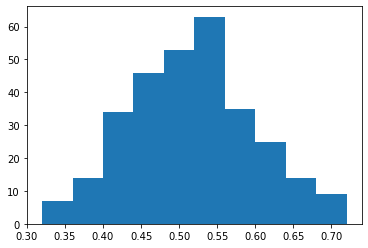

In [23]:
evals = list()
for i in range(300):
    evals.append(try_evaluate(i))
plt.hist(evals)

In [24]:
print("Mean: ", np.mean(evals))
print("Var: ", np.var(evals))
print("Std: ", np.std(evals))

Mean:  0.4968000000000001
Var:  0.006693760000000001
Std:  0.08181540197297818


### For Result

In [25]:
try_evaluate(20230618, True, True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.472
Date:                Sun, 18 Jun 2023   Prob (F-statistic):              0.211
Time:                        23:27:58   Log-Likelihood:                0.56938
No. Observations:                  49   AIC:                             12.86
Df Residuals:                      42   BIC:                             26.10
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3361      0.089      3.772      0.001       0.156       0.516
Subj_32        0.0062      0.064      0.098      0.923      -0.122       0.134
Subj_49        0.2334      0.102      2.289      0.027       0.028       0.439
Subj_71        0.0965      0.064      1.507      0.139      -0.033       0.226
Ans_1          0.1504      0.069      2.192      0.034       0.012       0.289
Ans_2          0.0094      0.066      0.144      0.886      -0.123       0.142
Ans_3         -0.0286      0.071     -0.405      0.687      -0.171       0.114
Ans_4          0.2048      0.084      2.435      0.019       0.035       0.375
CRRatio        0.1985      0.264      0.752      0.456      -0.334       0.731
==============================================================================
Omnibus:                        0.193   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.908   Jarque-Bera (JB):                0.295
Skew:                          -0.137   Prob(JB):                        0.863
Kurtosis:                       2.737   Cond. No.                     2.58e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.45e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Estimation
[1 2 1 1 1 2 2 1 2 1 1 2 2 1 2 1 2 2 1 1 2 1 2 2 2]
True
[2 1 1 2 1 1 1 1 1 2 2 1 2 1 1 1 2 2 2 1 2 1 2 1 2]
0.52


0.52

In [26]:
# export result
mydata[['QuestionId', 'ranking']].to_csv('submission/Result02.csv', index=False)

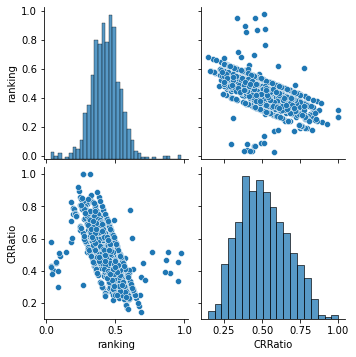

In [27]:
sns.pairplot(mydata[['ranking', 'CRRatio']])